# Relationship between TIVT/IVTmax and IVT variability

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Change path to working script directory
current_path=os.getcwd()
print(current_path)
major_path = os.path.abspath("../../../")
base_working_path=major_path+"/my_GIT/Synthetic_Airborne_Arctic_ARs"
aircraft_base_path=major_path+"/Work/GIT_Repository/"
working_path  = base_working_path+"/src/"
config_path   = base_working_path+"/config/"
plotting_path = base_working_path+"/plotting/"

sys.path.insert(1, os.path.join(sys.path[0], working_path))
sys.path.insert(2, os.path.join(sys.path[0], config_path))
sys.path.insert(3, os.path.join(sys.path[0], plotting_path))

print(working_path)
os.chdir(working_path)


C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\Synthetic_Airborne_Arctic_ARs\notebooks
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI/my_GIT/Synthetic_Airborne_Arctic_ARs/src/


In [3]:
import flightcampaign as Campaign
import flightmapping
import flight_track_creator
import data_config

Typhon module cannot be imported


In [4]:
# Config File
config_file=data_config.load_config_file(aircraft_base_path,"data_config_file")
analyse_all_flights=False
flight_dates={"North_Atlantic_Run":
              {"SRF02":"20180224",
               "SRF04":"20190319",#},
               "SRF07":"20200416",#},
               "SRF08":"20200419"
              },
              "Second_Synthetic_Study":
              {"SRF02":"20110317",
               "SRF03":"20110423",
               "SRF08":"20150314",
               "SRF09":"20160311",
               "SRF12":"20180225"
               }}
flight_tracks_dict={}
campaigns=[*flight_dates.keys()]
shifted_lat=0
shifted_lon=0
ar_of_day="SAR_internal"

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI/Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI/Work/GIT_Repository//data_config_file.ini.ini  already exists


In [5]:
import flight_track_creator

In [6]:
import atmospheric_rivers
import gridonhalo
from reanalysis import ERA5,CARRA
import ivtvariability as IVT_handler
from ivtvariability import IVT_variability

## Open IVT stats

In [15]:
ivt_stats_path="C://Users//u300737//Desktop//Desktop_alter_Rechner//PhD_UHH_WIMI//Work//GIT_Repository//Second_Synthetic_Study/data//"
ivt_stats_file="IVT_Stats_Overall_all_RFs.csv"
if os.path.exists(ivt_stats_path+ivt_stats_file):
    ivt_stats=pd.read_csv(ivt_stats_path+ivt_stats_file,index_col=0)
    ivt_stats.index=ivt_stats["flight"]
    ivt_stats=ivt_stats.sort_index()
    ivt_stats.describe()
    # CARRA ERA5 comparison
    print("Relative IVT mean increase:" , ivt_stats["IVT_mean"].mean()/ivt_stats["IVT_mean_ERA"].mean())
    print("Relative IVT max increase:"  , ivt_stats["IVT_max"].mean()/ivt_stats["IVT_max_ERA"].mean())
    print("Relative IVT std increase:"  , ivt_stats["IVT_std"].mean()/ivt_stats["IVT_std_ERA"].mean())

Relative IVT mean increase: 1.0840643781810404
Relative IVT max increase: 1.087648999970621
Relative IVT std increase: 1.1086515176526004


## Load TIVT soundings

In [16]:
TIVT_dict={}
p=0
for campaign in flight_dates.keys():
    for flight in flight_dates[campaign]:
        date=flight_dates[campaign][flight]
        if campaign=="Second_Synthetic_Study":
            cmpgn_cls=Campaign.Second_Synthetic_Study(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               
        else:
            cmpgn_cls=Campaign.North_Atlantic_February_Run(is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])
        TIVT_sounding_data_path=cmpgn_cls.campaign_data_path
        TIVT_sounding_inflow_filename="SAR_internal_"+flight+"_inflow_TIVT_Sonde_Resolution.csv"
        TIVT_sounding_outflow_filename="SAR_internal_"+flight+"_outflow_TIVT_Sonde_Resolution.csv"
        TIVT_dict[flight_dates[campaign][flight]+"_inflow"]=pd.read_csv(TIVT_sounding_data_path+\
                                                                       TIVT_sounding_inflow_filename,index_col=0)
        TIVT_dict[flight_dates[campaign][flight]+"_outflow"]=pd.read_csv(TIVT_sounding_data_path+\
                                                                       TIVT_sounding_outflow_filename,index_col=0)
        if os.path.exists(ivt_stats_path+ivt_stats_file):
            TIVT_dict[flight_dates[campaign][flight]+"_inflow"]["IVT_max"]=\
                ivt_stats["IVT_max"].iloc[2*p]
            TIVT_dict[flight_dates[campaign][flight]+"_outflow"]["IVT_max"]=\
                ivt_stats["IVT_max"].iloc[2*p+1]
        
        if p==0:
            TIVT_df=TIVT_dict[flight_dates[campaign][flight]+"_inflow"]
            TIVT_df=TIVT_df.append(TIVT_dict[flight_dates[campaign][flight]+"_outflow"])
        else:
            TIVT_df=TIVT_df.append(TIVT_dict[flight_dates[campaign][flight]+"_inflow"])
            TIVT_df=TIVT_df.append(TIVT_dict[flight_dates[campaign][flight]+"_outflow"])
        p+=1

Overall directory of campaign work is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository/Second_Synthetic_Study/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository/Second_Synthetic_Study/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository/Second_Synthetic_Study/
Overall directory of

In [17]:
rel_TIVT_df=TIVT_df.iloc[:,0:8]
# Calc relative deviation
for idx in range(rel_TIVT_df.shape[0]):
    rel_TIVT_df.iloc[idx,:]=(rel_TIVT_df.iloc[idx,:]-float(TIVT_df["REAL-CARRA-TIVT"].iloc[idx]))/\
                                float(TIVT_df["REAL-CARRA-TIVT"].iloc[idx])

rel_TIVT_df.index=range(rel_TIVT_df.shape[0])
TIVT_df.index=range(TIVT_df.shape[0])
rel_TIVT_df["IVT_max"]=TIVT_df["IVT_max"]
rel_TIVT_df["REAL-CARRA-TIVT"]=TIVT_df["REAL-CARRA-TIVT"]
# quantile_variable to analyse
quantile_variable="IVT_max"#"REAL-CARRA-TIVT"##"REAL-CARRA-TIVT"
weak_index=rel_TIVT_df[rel_TIVT_df[quantile_variable]<rel_TIVT_df[quantile_variable].describe()["25%"]]
strong_index=rel_TIVT_df[rel_TIVT_df[quantile_variable]>rel_TIVT_df[quantile_variable].describe()["75%"]]

In [39]:
#def distance_to_time(x):
#    air_speed=250 #m/s
#    return x/=air_speed
#def time_to_distance(x):
#    air_speed=250 #m/s
#    return x/=air_speed
#
distances=np.array([300,360,480,600,720,900,1200,1500])*air_speed/1000

#rel_TIVT_df

## Plotting

Figure successfully saved as:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI/Work/Synthetic_AR_Paper/Manuscript/Paper_Plots/fig06_CARRA_Synthetic_Sonde_Frequency_TIVT_BIAS_QIVT_max.png


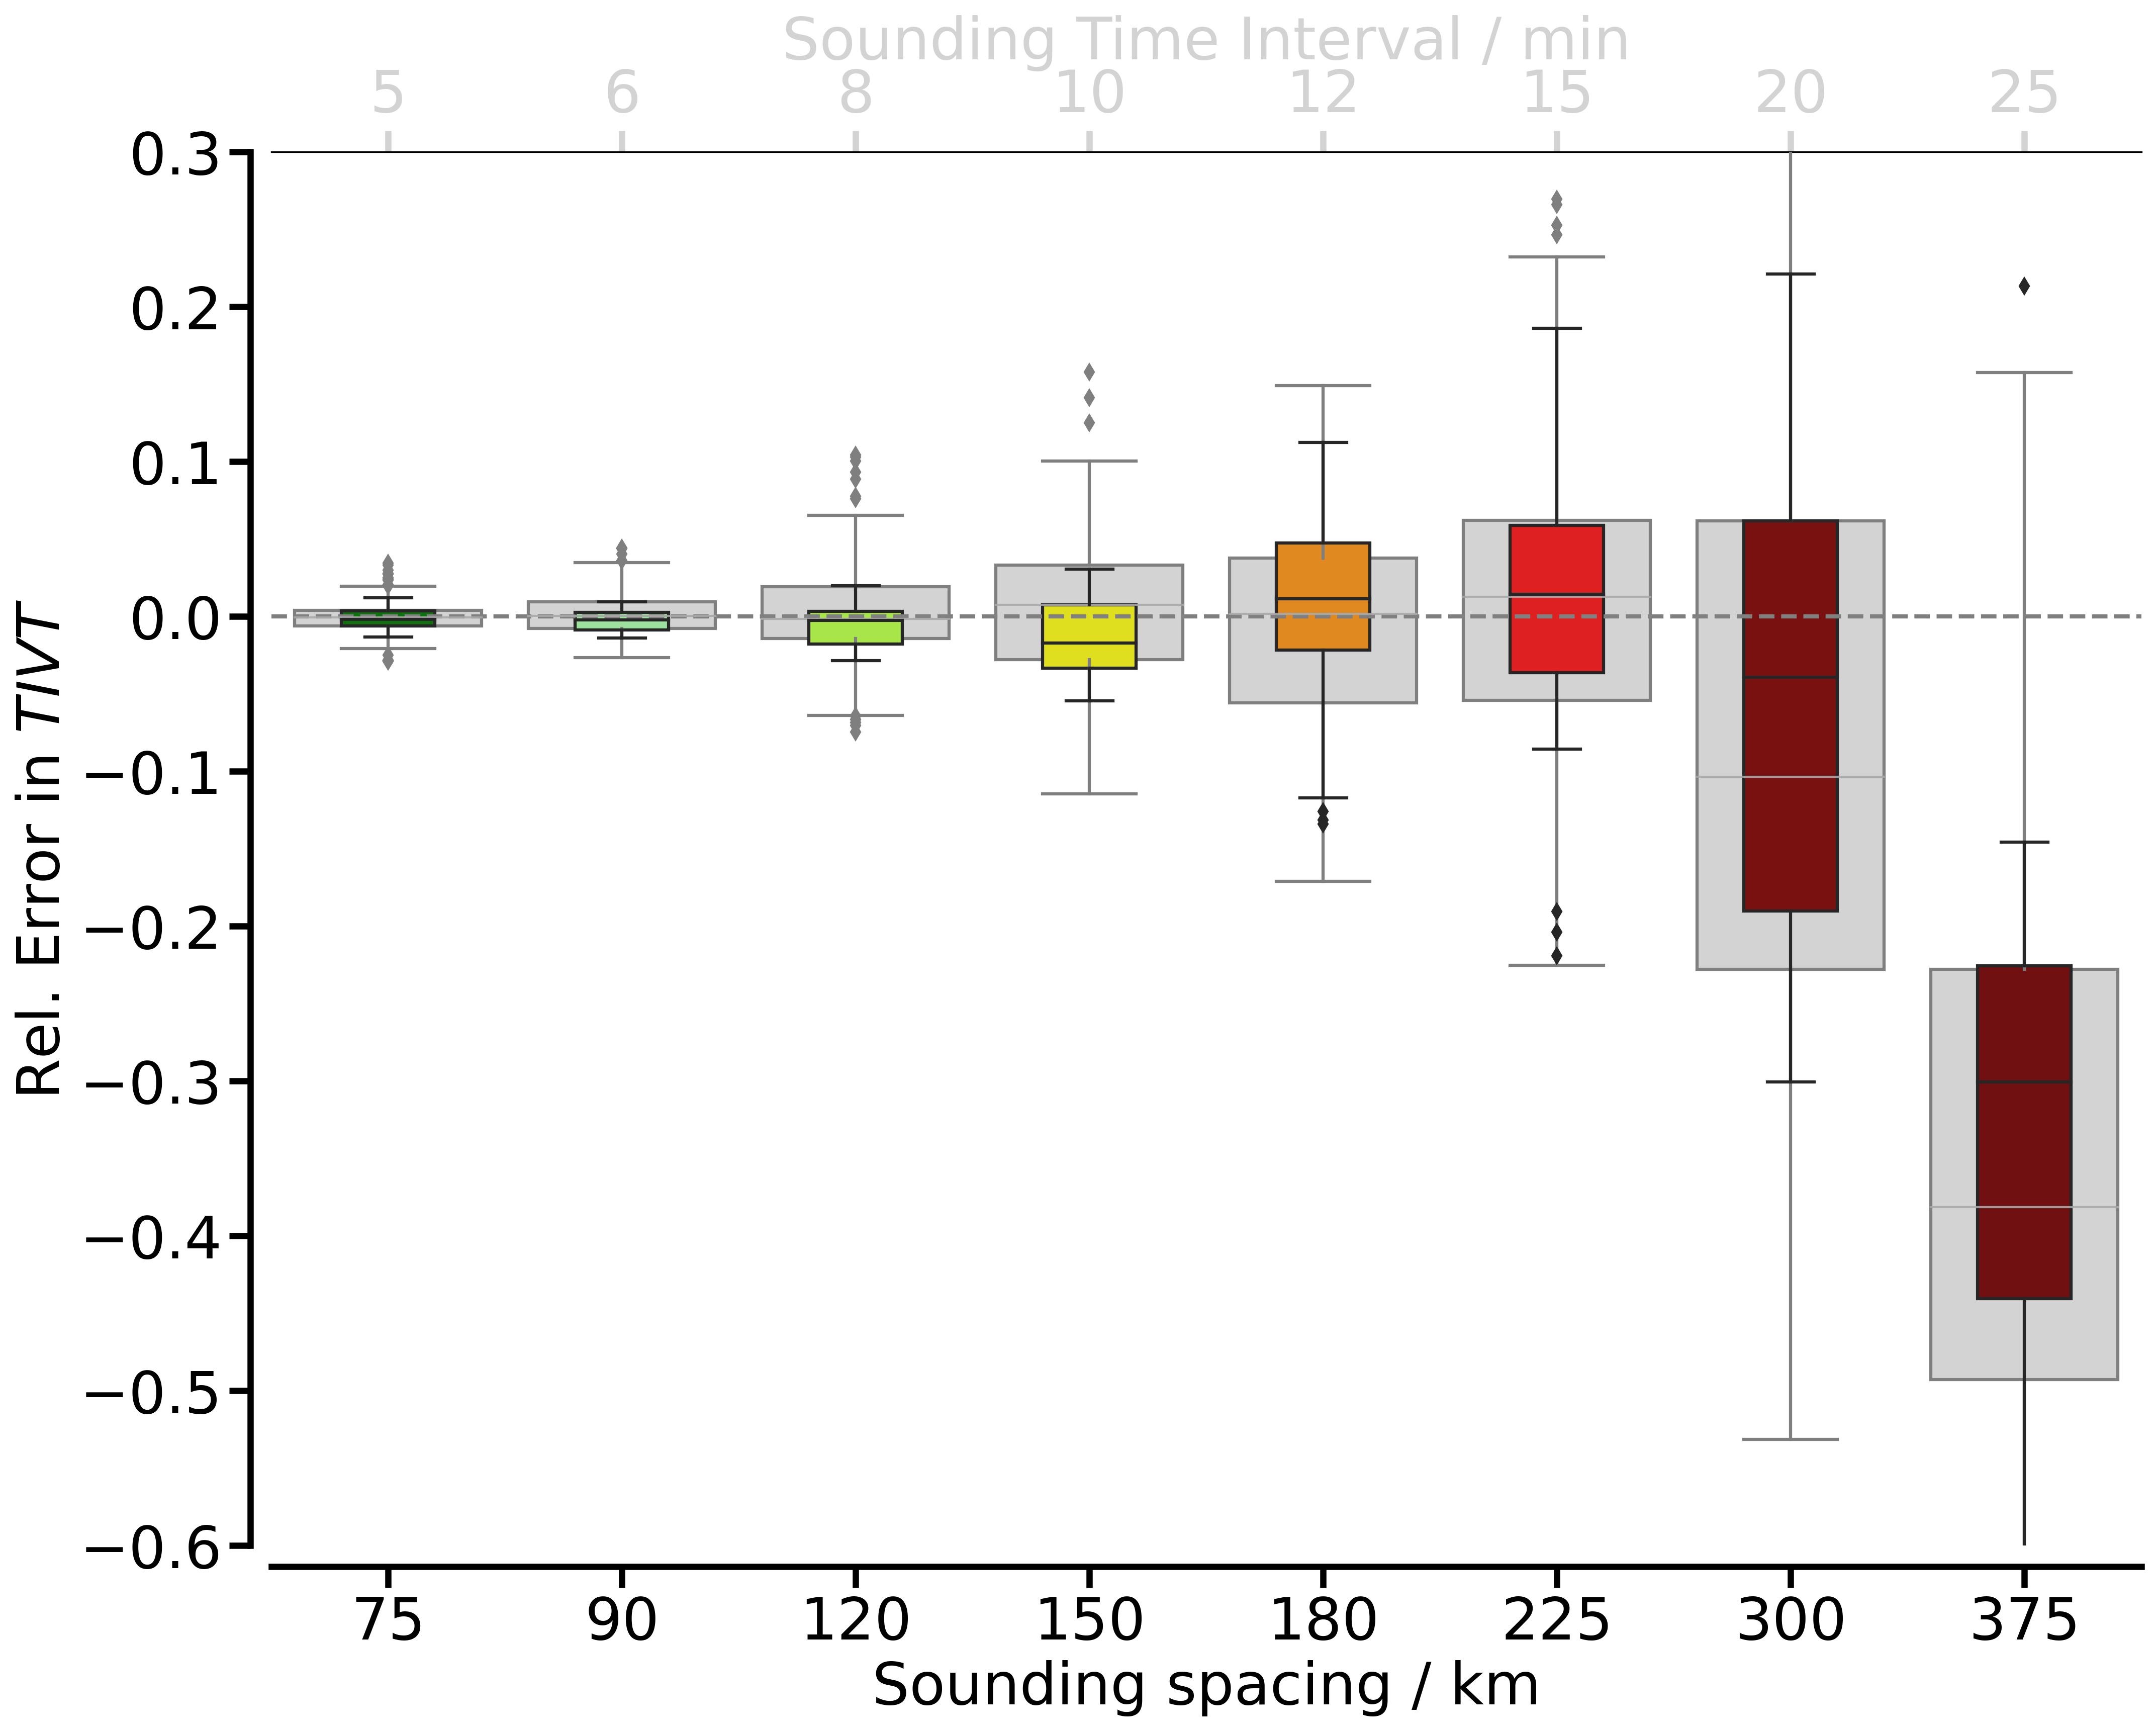

In [55]:
#Start plotting
from matplotlib import ticker as tick
import seaborn as sns
sonde_freq_fig=plt.figure(figsize=(16,12), dpi= 300)
matplotlib.rcParams.update({'font.size': 28})
x_var = 'Sounding distance in AR Cross-Section'
colors= {"1500s":"maroon","1200s":"darkred",
         "900s":"red","720s":"darkorange",
         "600s":"yellow","480s":"greenyellow",
         "360s":"lightgreen","300s":"green"}

ax1=sonde_freq_fig.add_subplot(111)
ax1.axhline(0,color="grey",ls="--",lw=2,zorder=1)
colors_taken           = [colors[sonde_no] for sonde_no in colors.keys()]

boxes=sns.boxplot(data=rel_TIVT_df.iloc[:,:-2],color="lightgrey", width=0.8,
                        notch=False,zorder=1,medianprops=dict(color="darkgrey", lw=1,alpha=0.9))
plt.setp(boxes.artists, edgecolor = 'k', facecolor='lightgrey')

strong_boxes=sns.boxplot(data=strong_index.iloc[:,:-2],width=0.4,palette=colors_taken[::-1],notch=False,zorder=3)
# iterate over boxes
for patch in strong_boxes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))

                
ax1.set_ylabel("Rel. Error in $TIVT$")
ax1.set_xlabel("Sounding spacing / km")
ax1.set_xticks([0,1,2,3,4,5,6,7])
ax1.set_xticklabels([str(int(distances[d])) for d in range(distances.shape[0])])
secax = ax1.secondary_xaxis('top')
secax.set_xlabel("Sounding Time Interval / min")
secax.set_xticks([0,1,2,3,4,5,6,7])
secax.set_xticklabels(["5","6","8","10","12","15","20","25"])
secax.xaxis.label.set_color('lightgrey')
secax.tick_params(axis='x', colors='lightgrey')
for axis in ["left","bottom"]:
    ax1.spines[axis].set_linewidth(3)
    secax.spines[axis].set_linewidth(3)
    secax.xaxis.set_tick_params(width=3,length=10)
    ax1.xaxis.set_tick_params(width=3,length=10)
    ax1.yaxis.set_tick_params(width=3,length=10)
#secax.xaxis.ticks.set_color('grey')

#secax.set_xlabel('period [s]')
sns.despine(offset=10)

ax1.set_ylim([-0.6,0.3])
fig_name="fig06_CARRA"+\
    "_Synthetic_Sonde_Frequency_TIVT_BIAS_Q"+quantile_variable+".png"
fig_path=major_path+"/Work/Synthetic_AR_Paper/Manuscript/Paper_Plots/"
sonde_freq_fig.savefig(fig_path+fig_name,dpi=200,bbox_inches="tight")
print("Figure successfully saved as: ",fig_path+fig_name)

## IVT Variability plots

Correlation R= 0.8058151555958196


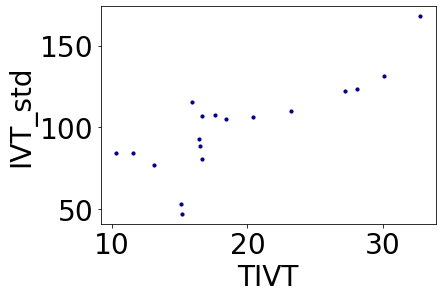

In [12]:
r=np.corrcoef(x=ivt_stats["TIVT"].astype(float),y=ivt_stats["IVT_std"].astype(float))
ivt_stats.plot.scatter(x="TIVT",y="IVT_std",s=10,color="darkblue")
print("Correlation R=",r[0,1])

Correlation R= 0.9212765687376306


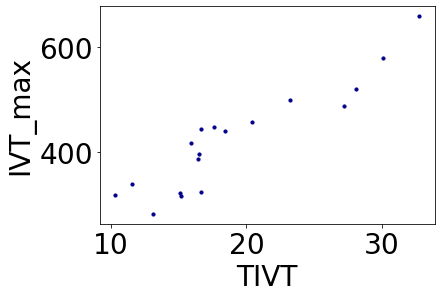

In [13]:
r=np.corrcoef(x=ivt_stats["TIVT"].astype(float),y=ivt_stats["IVT_max"].astype(float))
ivt_stats.plot.scatter(x="TIVT",y="IVT_max",s=10,color="darkblue")
print("Correlation R=",r[0,1])

Correlation R= 0.9233288120144223


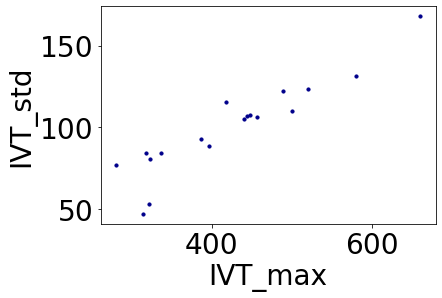

In [14]:
r=np.corrcoef(x=ivt_stats["IVT_max"].astype(float),y=ivt_stats["IVT_std"].astype(float))
ivt_stats.plot.scatter(x="IVT_max",y="IVT_std",s=10,color="darkblue")
print("Correlation R=",r[0,1])

In [15]:
ivt_var_plot_cls.plot_model_sounding_frequency_comparison(
                            name_of_grid_data="CARRA")

NameError: name 'ivt_var_plot_cls' is not defined

In [ ]:
r=np.corrcoef(x=ivt_stats["IVT_max"].astype(float),y=ivt_stats["TIVT"].astype(float))
ivt_stats.plot.scatter(x="IVT_max",y="TIVT",s=10,color="darkblue")
print("Correlation R=",r[0,1])